* Parkinsons Volatility (P Vol): high-low at t&(t-1)
* A lot of gamma (well supplied): a lot of ATM options 
* Calculating Vol:
    * Hist of time between fills
    * Group fills
    



    
* Vega bucketing


In [1]:
access_token = ""
import pandas as pd
import numpy as np
import datetime
from sklearn import linear_model
from matplotlib import pyplot as plt

In [2]:
import requests
import pandas as pd
def getReqDate(d):
    
    start = pd.to_datetime(d)
    sYear = str(start.year)
    sMonth = ""
    sDay = ""
    
    if(start.month <10):
        sMonth = "0"+ str(start.month)
    else:
        sMonth = str(start.month)
    
    if(start.day <10):
        sDay = "0"+ str(start.day)
    else:
        sDay = str(start.day)
    
    output = sYear+sMonth+sDay+"T000000"
    return output

def getData(start,end,timeFrame,pair):
    access_token = ""
    headers = {'Authorization': 'Bearer ' + access_token}
    fromDate = getReqDate(start)
    toDate = getReqDate(end)
    url = "https://api.cryptoquant.com/v1/"+pair+"/market-data/price-ohlcv?window="+timeFrame+"&from="+fromDate+"&to="+toDate+"&limit=100000"
    temp = pd.DataFrame(requests.get(url, headers=headers).json()['result']['data'])
    temp.sort_values(by = 'datetime',inplace=True)
    temp.index = pd.to_datetime(temp.datetime)
    check = pd.to_datetime(temp.index[0])
    check1 = pd.to_datetime(start)
    if check.year != check1.year or check.month != check1.month or check.day != check1.day:
        newEnd = check
        #print(newEnd)
        newDF = pd.concat([getData(start,newEnd,timeFrame,pair), temp])
        dupIndex = newDF.index.duplicated(keep="first")
        newDF = newDF[~dupIndex]
        newDF.sort_index(inplace=True)
        
        return newDF
    else:
        return temp


In [26]:
def stdLog(start,end,timeFrame,coin):
    df = getData(start,end,timeFrame,coin)
    return (np.log(df.close) - np.log(df.close.shift(1))).describe()["std"]

In [29]:
access_token = ""
#Format: YYYY-MM-DD
start = "2022-01-01"
end = "2022-03-15"
#Format: {"min","hour","day"}
timeFrame = "hour"
coin = 'btc'

In [28]:
stdLog(start,end,timeFrame,coin)*(24*365)**0.5

0.6556777979390889

In [40]:
df = getData(start,end,timeFrame,coin)
df['datetime'] = pd.to_datetime(df['datetime'])
df["logReturn"] = np.log(df.close) - np.log(df.close.shift(1))
df["vol"] = df['logReturn'].rolling(24).std()*(24*365)**0.5

In [41]:
'''
oil = pd.read_csv('CrudeOil.csv')
oil['date'] = pd.to_datetime(oil['DATE'])
oil['price'] = oil['DCOILWTICO']
oil = oil.drop(columns = ['DATE', 'DCOILWTICO'])
oil['exactDate'] = np.nan
for i, row in oil.iterrows():
    oil.at[i, 'exactDate'] = oil.date[i].date()
oil.drop_duplicates('exactDate',keep='last')
df['oilPrice'] = np.nan

for i, row in df.iterrows():
    print(i.date())
    print(oil.exactDate.values)
    if i.date() in oil.exactDate.values:
        df.at[i, 'oilPrice'] = oil.loc[oil['exactDate'] == i.date()].price
'''        
stf = pd.read_csv('BTCstf.csv')
stf['Datetime'] = pd.to_datetime(stf['Datetime'])
stf['stf'] = pd.to_numeric(stf['stf'])
stf.drop_duplicates('Datetime',keep='last')
df['stf'] = np.nan
for i, row in df.iterrows():
    if i in stf.Datetime.values:
        df.at[i, 'stf'] = stf.loc[stf.Datetime.values == i].stf

In [42]:
inflow = pd.read_csv('BTCInflow.csv')
inflow['Datetime'] = pd.to_datetime(inflow['Datetime'])
inflow['Inflow'] = pd.to_numeric(inflow['Inflow'])
inflow.drop_duplicates('Datetime',keep='last')
df['inflow'] = np.nan
for i, row in df.iterrows():
    if i in inflow.Datetime.values:
        df.at[i, 'inflow'] = inflow.loc[inflow.Datetime.values == i].Inflow
        

In [43]:
lev = pd.read_csv('BTCestLev.csv')
lev['Datetime'] = pd.to_datetime(lev['Datetime'])
lev['lev'] = pd.to_numeric(lev['estLev'])
lev.drop_duplicates('Datetime',keep='last')
df['lev'] = np.nan
for i, row in df.iterrows():
    if i in lev.Datetime.values:
        df.at[i, 'lev'] = lev.loc[lev.Datetime.values == i].lev

In [44]:
oi = pd.read_csv('BTCopenInterest.csv')
oi['Datetime'] = pd.to_datetime(oi['Datetime'])
oi['openInterest'] = pd.to_numeric(oi['openInterest'])
oi.drop_duplicates('Datetime',keep='last')
df['openInterest'] = np.nan
for i, row in df.iterrows():
    if i in oi.Datetime.values:
        df.at[i, 'openInterest'] = oi.loc[oi.Datetime.values == i].openInterest

In [45]:
corrs = df.corr()
corrs = corrs['vol']
corrs

open           -0.406902
high           -0.387111
low            -0.421900
close          -0.402219
volume          0.440232
logReturn       0.052248
vol             1.000000
stf             0.050885
inflow          0.347875
lev            -0.238964
openInterest   -0.419216
Name: vol, dtype: float64

In [9]:
dataSet = df[['volume', 'inflow', 'openInterest', 'lev', 'vol']].dropna()
X = dataSet[['volume', 'inflow', 'openInterest', 'lev']]
X = X.iloc[:-1]
y = dataSet['vol'].shift(-1).dropna()
regr = linear_model.LinearRegression()
regr = regr.fit(X, y)

In [10]:
df['predictedVol'] = np.nan
for i, row in df.iterrows():
    if not (np.isnan(row.volume) or np.isnan(row.inflow) or np.isnan(row.openInterest)):
        df.at[i+datetime.timedelta(hours=1), 'predictedVol'] = regr.predict([[row.volume, row.inflow, row.openInterest, row.lev]])

C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\TBaker\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does 

In [11]:
regr.score(X, y)

0.36797261108101054

In [20]:
df.vol.mean()

0.6526268854865579

In [18]:
df

,datetime,open,high,low,close,volume,logReturn,vol,oilPrice,inflow,stf,lev,openInterest,predictedVol
datetime,,,,,,,,,,,,,,
2022-03-16 00:00:00,2022-03-16 00:00:00,39295.062618,39442.418329,39134.783644,39183.841407,3500.074975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16 01:00:00,2022-03-16 01:00:00,39183.102434,39639.133538,39110.190047,39525.364900,4005.882090,0.008678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16 02:00:00,2022-03-16 02:00:00,39525.465141,41735.158286,39482.955866,40878.903126,29687.718163,0.033671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16 03:00:00,2022-03-16 03:00:00,40877.732021,40952.042019,38831.538581,39168.495321,20849.203984,-0.042741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16 04:00:00,2022-03-16 04:00:00,39165.271820,39224.564523,38932.850017,39124.877196,4178.195202,-0.001114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-08 21:00:00,2022-06-08 21:00:00,30181.441362,30492.488460,30177.355381,30410.653360,2785.847319,0.007517,0.862927,121.94,750.530502,381244.1709,0.283510,1.032103e+10,0.628292
2022-06-08 22:00:00,2022-06-08 22:00:00,30413.138673,30447.884975,30268.675535,30312.880176,2314.326517,-0.003220,0.861147,121.94,710.749457,609991.6734,0.283737,1.029656e+10,0.642766
2022-06-08 23:00:00,2022-06-08 23:00:00,30309.911463,30359.887449,30172.861669,30209.770599,2454.784804,-0.003407,0.860918,121.94,428.047402,508327.3945,0.284311,1.028167e+10,0.632654


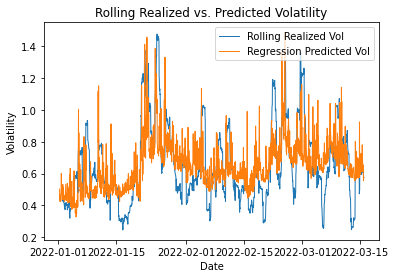

In [17]:
plt.plot(df.datetime, df.vol, label = 'Rolling Realized Vol', linewidth = 1)
plt.plot(df.datetime, df.predictedVol, label = 'Regression Predicted Vol', linewidth = 1) 
plt.title('Rolling Realized vs. Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

<AxesSubplot:>

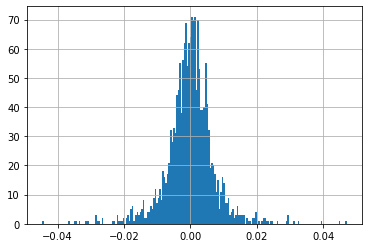

In [23]:
df['logReturn'].hist(bins = 200)